## 🔧 Librerías utilizadas

En este cuaderno se utilizan librerías estándar de Python para procesamiento de datos, aprendizaje automático y visualización. `matplotlib` para graficar resultados.


Nombre: Elmer Kevin Vela Gutierrez CICO 

In [16]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples


## 📥 Carga y preparación de datos

Se carga el dataset original de partidas de ajedrez. Seleccionamos únicamente las columnas numéricas más relevantes: `turns`, `white_rating`, y `black_rating`. Estas variables permitirán realizar un agrupamiento basado en el estilo y nivel de juego.


In [17]:
# 2. Cargar y preparar el dataset
df = pd.read_csv("games.csv")
data = df[['turns', 'white_rating', 'black_rating']].dropna()

# Escalar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Reducir dimensiones para visualizar en 2D
pca = PCA(n_components=2)
X = pca.fit_transform(scaled_data)


## 🔎 Evaluación del número óptimo de clústeres

Se utiliza el coeficiente de Silhouette para evaluar la calidad del agrupamiento en función del número de clústeres. Este valor mide qué tan similar es un punto a su propio clúster comparado con otros. Se prueba con `k` desde 2 hasta 9.


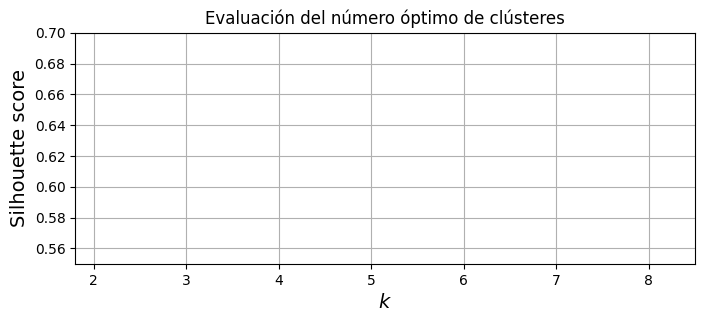

In [18]:
# 3. Evaluar distintos valores de k con Silhouette Score
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

# Gráfico del Silhouette Score por k
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Evaluación del número óptimo de clústeres")
plt.grid(True)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()


## 🤖 Aplicación de KMeans

Una vez identificado el mejor valor de `k` (en este caso, 4), se aplica el algoritmo KMeans para realizar el agrupamiento de las partidas. Cada punto será asignado a uno de los 4 clústeres resultantes.


In [19]:
# 4. Aplicar KMeans con el mejor k
k = 4  # Cambiar si otro valor es mejor
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)


## 🗺️ Visualización de clústeres y fronteras

Se genera una visualización tipo Voronoi donde cada región representa un clúster. Los centroides se destacan con una 'X' y un círculo. Esta representación permite observar cómo se segmenta el espacio en función de los datos.


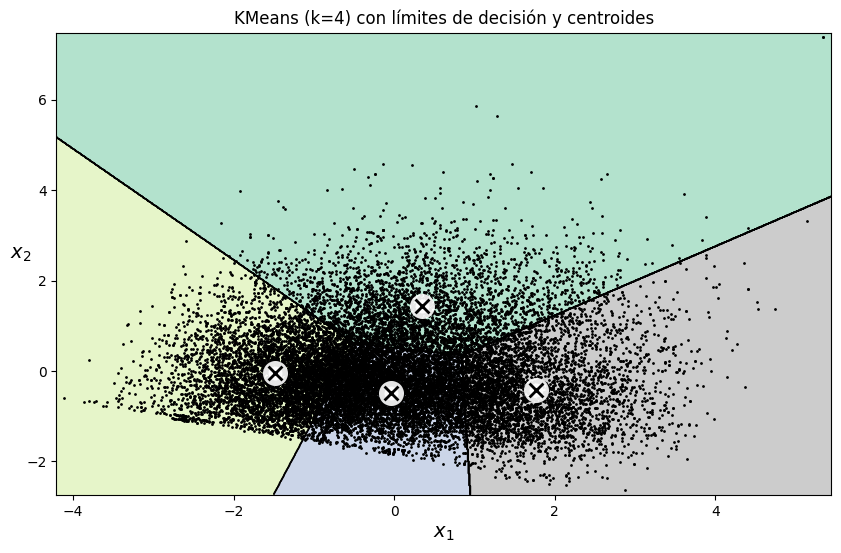

In [20]:
# 5. Visualización Voronoi con centroides
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, circle_color='w', cross_color='k'):
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=100,
                linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100,
                linewidths=2, color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors='k')
    plot_data(X)
    plot_centroids(clusterer.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans, X)
plt.title(f"KMeans (k={k}) con límites de decisión y centroides")
plt.show()


## 🔮 Clasificación de nuevas observaciones

Se introducen nuevas coordenadas (por ejemplo, representando partidas hipotéticas) para que el modelo las clasifique dentro de uno de los clústeres previamente definidos. Esto permite validar el poder predictivo del modelo.


In [21]:
# 6. Predicción para nuevos puntos
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
predictions = kmeans.predict(X_new)
print("Predicciones para nuevos puntos:", predictions)


Predicciones para nuevos puntos: [0 0 2 2]


## 📊 Gráfico de Coeficientes de Silueta

Este gráfico muestra la densidad y cohesión de cada clúster. Cuanto mayor sea el área a la derecha (cercana a 1), mejor está definido ese grupo. Una línea roja marca el promedio global. Este gráfico ayuda a detectar si algún clúster está débilmente agrupado.


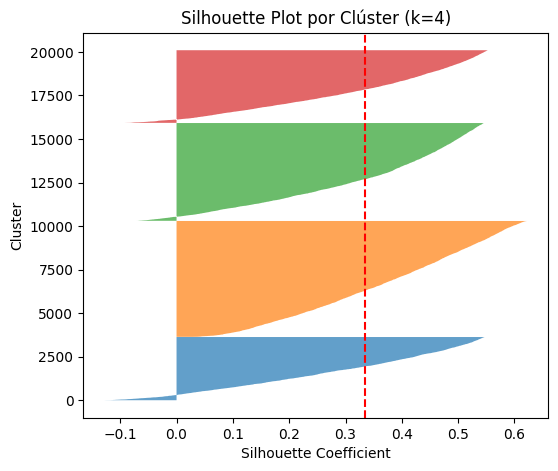

In [22]:
# 7. Gráfico de Coeficientes de Silueta por clúster
silhouette_vals = silhouette_samples(X, y_pred)
y_lower = 10
plt.figure(figsize=(6, 5))

for i in range(k):
    ith_cluster_silhouette_values = silhouette_vals[y_pred == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values, alpha=0.7)
    y_lower = y_upper + 10

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.title("Silhouette Plot por Clúster (k=4)")
plt.show()




El algoritmo KMeans permitió agrupar las partidas de ajedrez en 4 segmentos distintos según el comportamiento y nivel de los jugadores. El análisis de Silhouette confirmó que los clústeres presentan una separación razonable. Este enfoque puede escalarse para recomendar emparejamientos, identificar tipos de partidas o personalizar entrenamientos.

Este pipeline demuestra cómo aplicar clustering no supervisado con criterios sólidos, visualizaciones comprensibles y aplicación práctica en datos reales.
